## Set up local torch and torchvision

In [1]:
import torch
import torchvision
import syft as sy

# Lets define a few settings which are from the original MNIST example command line args
args = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": True,
}

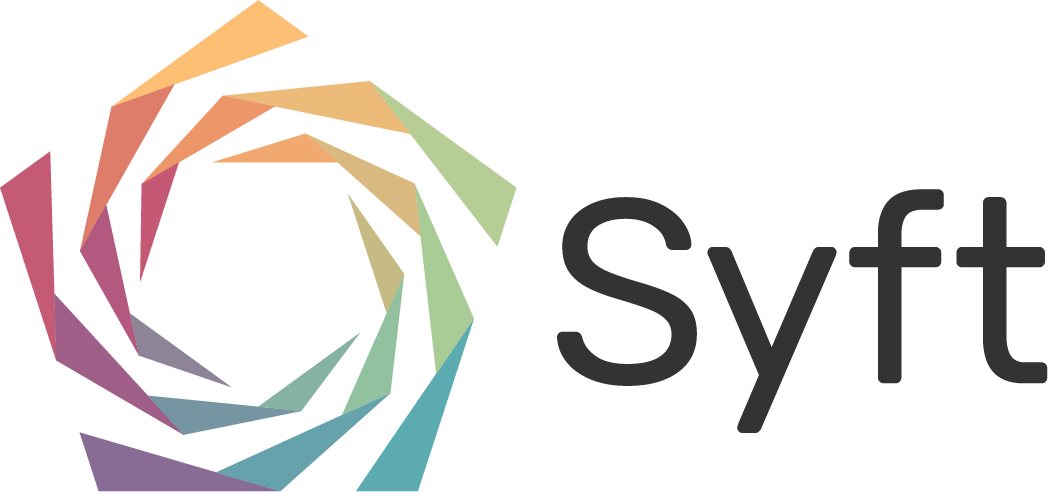

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.

♫♫♫ > 
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!

♫♫♫ > Duet Client ID: 44255d62526984fe4bca0d12ee86fc69

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!


In [2]:
duet = sy.duet("49dec020e256a1c043a640f23836b7c5")

## Put Data in the Starting Positions

In [3]:
# we will configure the test set here locally since we want to know if our Data Owner's
# private training dataset will help us reach new SOTA results for our benchmark test set
train_kwargs = {
    "batch_size": args["batch_size"],
}

# we need some transforms for the MNIST data set
local_transform_1 = torchvision.transforms.ToTensor()  # this converts PIL images to Tensors
local_transform_2 = torchvision.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

# compose our transforms
local_transforms = torchvision.transforms.Compose([local_transform_1, local_transform_2])

local_train_data = torchvision.datasets.MNIST('../data', train=True, download=True, transform=local_transforms)
local_train_loader = torch.utils.data.DataLoader(local_train_data,**train_kwargs)

labels = []
remote_images = []

for image, label in local_train_loader:
    labels.append(label)
    remote_images.append(image.send(duet))

## Define and build the output model for the labels

In [4]:
class SyNet2(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet2, self).__init__(torch_ref=torch_ref)
        self.dropout1 = self.torch_ref.nn.Dropout2d(0.25)
        self.dropout2 = self.torch_ref.nn.Dropout2d(0.5)
        self.fc1 = self.torch_ref.nn.Linear(9216, 128)
        self.fc2 = self.torch_ref.nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.torch_ref.flatten(x, 1)
        x = self.fc1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.torch_ref.nn.functional.log_softmax(x, dim=1)
        return output
    
output_model = SyNet2(torch)
output_params = output_model.parameters()
output_optimizer = torch.optim.Adadelta(output_params, lr=args["lr"])
output_scheduler = torch.optim.lr_scheduler.StepLR(output_optimizer, step_size=1, gamma=args["gamma"])



> Creating local model


## Define, build and send the input model for the remote images

In [14]:
remote_torchvision = duet.torchvision
remote_torch = duet.torch

class SyNet1(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet1, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = self.torch_ref.nn.Conv2d(32, 64, 3, 1) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.torch_ref.nn.functional.max_pool2d(x, 2)
        output = self.torch_ref.nn.functional.log_softmax(x, dim=1)
        return output
    
    
input_model = SyNet1(torch)
input_model_ptr = input_model.send(duet)
input_params = input_model.parameters()
input_optimizer = remote_torch.optim.Adadelta(input_params, lr=args["lr"])
input_scheduler = remote_torch.optim.lr_scheduler.StepLR(input_optimizer, step_size=1, gamma=args["gamma"])

> Creating local model
> Sending local model
> Creating remote model
  Sending local layer: conv1
  Sending local layer: conv2

> Finished sending local model <




## Experimental Section - 
(Demonstrates Jacobian Backprop Issue)

In [6]:
input_optimizer.zero_grad()
output_optimizer.zero_grad()

# Send data through the client portion of the model
remote_activation = input_model_ptr(remote_images[0])
remote_activation.retain_graph=True

In [7]:
#Clone the resultant activation signal, retrieve to server side
local_activation = remote_activation.clone().detach()
local_activation = local_activation.get(
        request_block=False,
        name="activation",
        reason="To process the rest of the model",
        timeout_secs=-1,
        )

local_activation.requires_grad=True

In [8]:
#Perform prediction using activation signal on server side
predictions = output_model(local_activation)

# # Compute Loss calculate grads of server side model
loss = torch.nn.functional.nll_loss(predictions, labels[0])
loss.backward()
print(local_activation.grad)

tensor([[[[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          ...,
          [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00]],

         [[-1.0356e-04,  5.3643e-05, -6.6918e-05,  ..., -2.4967e-05,
            2.4708e-05,  4.2877e-05],
          [ 1.9480e-05,  7.8412e-05, -8.8747e-05,  ...,  9.4456e-05,
           -2.8573e-05,  8.2686e-05],
          [-1.6628e-05,  5.2199e-05, -8.9763e-05,  ...,  1.5731e-05,
           -1.8175e-04, -5.6378e-05],
          ...,
     

In [9]:
## Clone the gradient value, check if it looks right
grad = local_activation.grad.clone()
print(grad)

tensor([[[[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          ...,
          [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00]],

         [[-1.0356e-04,  5.3643e-05, -6.6918e-05,  ..., -2.4967e-05,
            2.4708e-05,  4.2877e-05],
          [ 1.9480e-05,  7.8412e-05, -8.8747e-05,  ...,  9.4456e-05,
           -2.8573e-05,  8.2686e-05],
          [-1.6628e-05,  5.2199e-05, -8.9763e-05,  ...,  1.5731e-05,
           -1.8175e-04, -5.6378e-05],
          ...,
     

In [10]:
#send gradient to duet, compute Jacobian backprop
grad_ptr = grad.send(duet)
remote_activation.backward(grad_ptr)

In [11]:
## pull back remote model
model1 = input_model_ptr.get(
        request_block=False,
        name="activation",
        reason="To process the rest of the model",
        timeout_secs=-1,
        )

> Downloading remote model
> Creating local model

> Finished downloading remote model <




In [12]:
## Check if the gradients have backpropogated to the remote model
print(model1.parameters()[-1].grad)

None


# Rest of notebook for complete training once Jacobian backprop is fixed

In [28]:
for x in range(args["epochs"]):
    loss = 0
#     included_batches = len(labels)-1
    included_batches = 3
    for y in range (included_batches):
        print("Batch {} of {}".format(y, included_batches))


        input_optimizer.zero_grad()
        output_optimizer.zero_grad()

        remote_activation = input_model_ptr(remote_images[y])
        local_activation = remote_activation.clone().detach()
        local_activation = local_activation.get(
                request_block=False,
                name="activation",
                reason="To process the rest of the model",
                timeout_secs=-1,
                )
        local_activation.requires_grad = True
        predictions = output_model(local_activation)

        # Compute Loss calculate grads of server side model
        loss = torch.nn.functional.nll_loss(predictions, labels[y])
        loss.backward()

        # Feed error back through client side model
        local_activation = local_activation.send(duet)
        remote_activation.backward(local_activation.grad())

        input_optimizer.step()
        output_optimizer.step()
    print(loss)


Batch 0 of 3
Batch 1 of 3
Batch 2 of 3
tensor(2.3016, grad_fn=<NllLossBackward>)
Batch 0 of 3
Batch 1 of 3
Batch 2 of 3


KeyboardInterrupt: 